# 10.5 

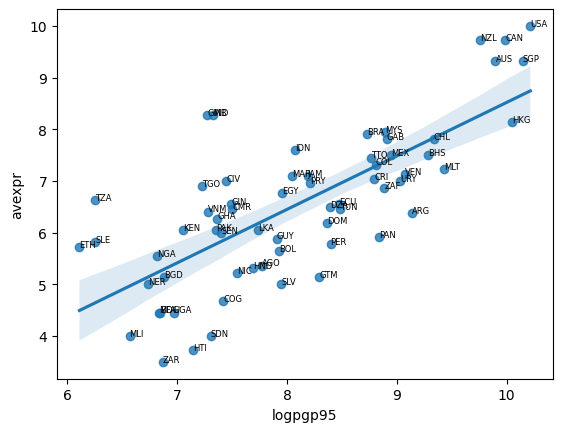

,shortnam,lat_abst,avexpr,logpgp95,logem4
0,AGO,0.136667,5.363636,7.770645,5.634789
1,ARG,0.377778,6.386364,9.133459,4.232656
2,AUS,0.300000,9.318182,9.897972,2.145931
3,BFA,0.144444,4.454545,6.845880,5.634789
4,BGD,0.266667,5.136364,6.877296,4.268438
...,...,...,...,...,...
59,USA,0.422222,10.000000,10.215740,2.708050
60,VEN,0.088889,7.136364,9.071078,4.357990
61,VNM,0.177778,6.409091,7.279319,4.941642
62,ZAF,0.322222,6.863636,8.885994,2.740840


In [1]:
# (1)
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.iv import  IV2SLS, IVLIML

ac = pd.read_stata('../2_Data/Data-2e/acemoglu.dta')

sns.regplot(x='logpgp95', y='avexpr', data=ac)
for index, row in ac.iterrows():
    plt.text(row['logpgp95'], row['avexpr'], str(row['shortnam']), fontsize=6)

plt.show()
ac

In [5]:
# (2)
dependent = ac['logpgp95']
exog = ac[['avexpr', 'lat_abst']]
exog = sm.add_constant(exog)
res_rubost = IV2SLS(dependent, exog, None,  None).fit()
print(res_rubost)

                            OLS Estimation Summary                            
Dep. Variable:               logpgp95   R-squared:                      0.5745
Estimator:                        OLS   Adj. R-squared:                 0.5605
No. Observations:                  64   F-statistic:                    136.20
Date:                Sat, Apr 27 2024   P-value (F-stat)                0.0000
Time:                        01:23:32   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.7281     0.3333     14.187     0.0000      4.0749      5.3813
avexpr         0.4679     0.0612     7.6459     0.00

In [9]:
# (3)
exog_iv = ac[['lat_abst']]
exog_iv = sm.add_constant(exog_iv)
endog = ac['avexpr']
instruments = ac[['logem4']]
model_iv = IV2SLS(dependent=dependent, exog=exog_iv, endog=endog, instruments=instruments)
res_2sls = model_iv.fit()
print(res_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1025
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0730
No. Observations:                  64   F-statistic:                    28.333
Date:                Sat, Apr 27 2024   P-value (F-stat)                0.0000
Time:                        01:28:13   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.6918     1.4478     1.1686     0.2426     -1.1458      4.5294
lat_abst      -0.6472     1.2270    -0.5275     0.59

In [23]:
# 对模型进行DWH检验，结果为 存在内生变量，2sls有效
print(res_2sls.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 18.7508
P-value: 0.0001
Distributed: F(1,60)


In [14]:
# (4)
print(model_iv.fit(cov_type='unadjusted').first_stage.individual) # 第一阶段完整结果 
print('============================================================================')
print(model_iv.fit(cov_type='unadjusted').first_stage.diagnostics) 

{'avexpr':                             OLS Estimation Summary                            
Dep. Variable:                 avexpr   R-squared:                      0.2960
Estimator:                        OLS   Adj. R-squared:                 0.2729
No. Observations:                  64   F-statistic:                    26.909
Date:                Sat, Apr 27 2024   P-value (F-stat)                0.0000
Time:                        01:30:34   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          8.5294     0.7930     10.755     0.0000      6.9751      10.084
lat_abst       2.0018     1.3055     1.53

# 10.6

In [28]:
# (1)
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from linearmodels.iv import  IV2SLS, IVLIML

def get_2sls_report(dataset, dependent, exog, endog, instruments):
    dependent = dataset[dependent]
    exog = dataset[exog]
    endog = dataset[endog]
    instruments = dataset[instruments]
    model_init = IV2SLS(dependent, 
                        sm.add_constant(pd.concat([exog, endog]),axis=1), 
                        None, 
                        None)
    res_init = model_init.fit()
    print(res_init.summary)
    
    model_ols = IV2SLS(dependent, exog, None, None)
    res_ols = model_ols.fit()
   
    model_iv_2sls = IV2SLS(dependent, exog, endog, instruments)
    res_iv_2sls = model_iv_2sls.fit()
    
    model_iv_liml = IVLIML(dependent, exog, endog, instruments)
    res_iv_liml = model_iv_liml.fit()
    return res_init, res_ols,res_iv_2sls, res_iv_liml

fs = pd.read_stata('../2_Data/Data-2e/fertility_small.dta')
fs.head()

,morekids,boy1st,boy2nd,samesex,age,black,hispan,othrace,weeks
0,0,0,0,1,35,0,0,0,40
1,0,0,1,0,33,0,0,0,52
2,0,0,0,1,28,0,0,0,12
3,0,1,1,1,28,0,0,0,0
4,0,0,1,0,31,0,0,0,0


In [34]:
dep = fs['weeks']
exo = fs[['morekids']]
exo = sm.add_constant(exo)
# endog = fs['']
# iv = fs[['age', 'education', 'income']]
model_ols = IV2SLS(dependent=dep, exog=exo, endog=None, instruments=None)
result_ols = model_iv.fit()
print(result_ols.summary)

                            OLS Estimation Summary                            
Dep. Variable:                  weeks   R-squared:                      0.0176
Estimator:                        OLS   Adj. R-squared:                 0.0176
No. Observations:               30000   F-statistic:                    559.12
Date:                Sat, Apr 27 2024   P-value (F-stat)                0.0000
Time:                        01:50:47   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          21.478     0.1637     131.22     0.0000      21.157      21.799
morekids      -6.0082     0.2541    -23.646     0.00

In [40]:
dep = fs['weeks']
exo = fs[['morekids']]

pd = pd.concat([dep, exo], axis=1)
pd

,weeks,morekids
0,40,0
1,52,0
2,12,0
3,0,0
4,0,0
...,...,...
29995,0,1
29996,4,0
29997,42,1
29998,52,1
